In [1]:
import h5py
import xml.etree.ElementTree as ET
from chemspipy import ChemSpider
import time
import random
import concurrent.futures
import gued_theory as gt
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'chemspipy'

In [44]:
def list_groups(file_name):
    with h5py.File(file_name, 'r') as f:
        print("Groups in the file:")
        for group_name in f.keys():
            print(group_name)


In [2]:
API_KEY = '67ABV69AUpV3Q0ALBQA69zcGjqGbYCby'
FILE_NAME = 'packages\\molecular_coordinates\\training_set.h5'
cs = ChemSpider(API_KEY)
MAX_WORKERS = 6


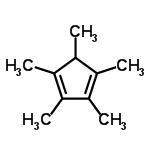

In [3]:
cs.get_compound(70069)

In [4]:
def mol2_to_xyz(mol2_str):
    atoms_section = False
    coor = []

    mol2_str = mol2_str.split('\n')
    start = 4 
    max_line = len(mol2_str)
    for i in range(start, max_line):
        string = mol2_str[i].split()
        #print(string)
        if len(string) > 10:
            atom_name = string[3]
            x = np.float64(string[0])
            y = np.float64(string[1])
            z = np.float64(string[2])
            coor.append([atom_name, x, y, z])
    coor = np.array(coor)
    atom_sum = len(coor)
    return coor, atom_sum

In [11]:
#c = cs.get_compound(1234)
c = cs.get_details(123)
coor, atom_sum = gt.mol2_to_xyz(c['mol2D'])
coor = gt._get_modified_coor(coor, atom_sum)
#_, I_atom, I_mol, s_new = gt.get_I_from_xyz(coor, atom_sum)

# plt.figure()
# plt.plot(s_new, (s_new*(I_mol/I_atom)))
# plt.show()


In [15]:
np.array(coor[0])

array(['O', '0.0', '-3.9821', '0.0', '8'], dtype='<U32')

In [48]:
def add_to_h5(file_name, group_name, csid, data_dict, group_note=None):
    """
    Dictionary should include atom_identity, xyz coordinates, maybe mass and charge? Also simulated scattering pattern"""
    with h5py.File(file_name, 'a') as f:
        # Create or access the group
        if group_name in f:
            group = f[group_name]
        else:
            group = f.create_group(group_name)

        # Add a description of the data (if provided)
        if group_note != None:
            group.attrs['note'] = group_note

        for dataset_name, data in data_dict.items():
            # Append run number to the dataset name
            run_dataset_name = f"{dataset_name}_{csid}"
    
            # Create or overwrite the dataset within the group
            if run_dataset_name in group:
                del group[run_dataset_name]
            group.create_dataset(run_dataset_name, data=data)
        
    return(f"Data for molecule {csid} saved to group '{group_name}' in {FILE_NAME} successfully.")


def cml_to_xyz(cml_file, xyz_file):
    # Parse the CML file
    tree = ET.parse(cml_file)
    root = tree.getroot()

    # Extract atom information
    atoms = []
    for atom in root.findall(".//{http://www.xml-cml.org/schema}atom"):
        symbol = atom.get("elementType")
        x = atom.get("x3")
        y = atom.get("y3")
        z = atom.get("z3")
        atoms.append((symbol, float(x), float(y), float(z)))

    # Write the XYZ file
    with open(xyz_file, "w") as f:
        f.write(f"{len(atoms)}\n\n")  # Number of atoms and a blank line
        for atom in atoms:
            f.write(f"{atom[0]} {atom[1]:.5f} {atom[2]:.5f} {atom[3]:.5f}\n")

def print_h5_structure(name, obj):
    # Print the name of the object (group or dataset)
    print(name)
    # Print attributes of the object, if any
    for key, value in obj.attrs.items():
        print(f"  Attribute: {key} = {value}")

# Function to count groups in the HDF5 file
def count_groups(file):
    group_count = 0
    
    def count_groups_recursive(name, obj):
        nonlocal group_count
        if isinstance(obj, h5py.Group):
            group_count += 1

    # Open the HDF5 file in read mode
    with h5py.File(file, 'r') as h5file:
        # Traverse the file to count groups
        h5file.visititems(count_groups_recursive)

    return group_count


In [49]:

def save_many_structures(elements_in, elements_out, include_all=True, complexity='single', max_amount = 100):
    print("Searching ChemSpider...")
    search = cs.filter_element(elements_in, elements_out, include_all = include_all, complexity=complexity)

    while cs.filter_status(search)['status'] != 'Complete':
        time.sleep(1E-3)
    print(cs.filter_status(search))
    cids = cs.filter_results(search)
    # Define the range for the indices


    rand_mols = random.sample(cids, max_amount)
    with h5py.File(FILE_NAME, 'a') as f:
        # Create or access the group
        print("Writing h5 file")
        for idx in rand_mols:
            mol = cs.get_details(idx)
            coor, atom_sum = gt.mol2_to_xyz(mol['mol2D'])
            coor = gt._get_modified_coor(coor, atom_sum)
            #mol['xyz'] = [coor]
            _, I_at, I_mol, s_new = gt.get_I_from_xyz(coor, atom_sum)
            sM = s_new * (I_mol/I_at)
            group_name = f"{mol['id']}"
            mol['sM'] = [sM]
            
            print(group_name)
            if group_name in f:
                group = f[group_name]
                print(f"Rewriting group {group_name}")
            else:
                group = f.create_group(group_name)

            group.attrs['note'] = f"Random download set featuring {elements_in} and without {elements_out}"
            repeat = 0
            for dataset_name, data in mol.items():
            # Append run number to the dataset name
                run_dataset_name = f"{dataset_name}"
        
                # Create or overwrite the dataset within the group
                if run_dataset_name in group:
                    repeat =+ 1 
                    del group[run_dataset_name]

                group.create_dataset(run_dataset_name, data=data)
                time.sleep(1E-2)
        print(f"Data for {len(rand_mols)} molecules saved to group in {FILE_NAME} successfully with {repeat} repeats.")



In [19]:
save_many_structures(['H', 'C', 'Br'], ['D'], max_amount=10)

Searching ChemSpider...
{'count': 10000, 'message': '', 'status': 'Complete'}
Writing h5 file
188365
27636
214897
247274
260074
226633
15452
208349
213726
204986
Data for 10 molecules saved to group in packages\molecular_coordinates\training_set.h5 successfully with 0 repeats.


In [53]:
API_KEY = 'N0EtG7PmkrUVkq2AIddr9WFs8kyGb5lJ'
FILE_NAME = 'packages\\molecular_coordinates\\training_set.h5'
cs = ChemSpider(API_KEY)
MAX_WORKERS = 6

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(save_many_structures, ['H', 'C', 'I'], ['D', 'N', 'O'], max_amount=50) for _ in range(5)]
    for r in concurrent.futures.as_completed(results):
        print(r.result)

Searching ChemSpider...
Searching ChemSpider...
Searching ChemSpider...
Searching ChemSpider...
Searching ChemSpider...
<bound method Future.result of <Future at 0x23cf8cb1110 state=finished raised ChemSpiPyUnavailableError>>
<bound method Future.result of <Future at 0x23cf8cb3190 state=finished raised ChemSpiPyUnavailableError>>
<bound method Future.result of <Future at 0x23cf8cae950 state=finished raised ChemSpiPyUnavailableError>>
<bound method Future.result of <Future at 0x23cf91fa110 state=finished raised ChemSpiPyUnavailableError>>
<bound method Future.result of <Future at 0x23cf8ca1ad0 state=finished raised ChemSpiPyUnavailableError>>


In [51]:
num_groups = count_groups(FILE_NAME)
print(num_groups)

3158


In [22]:
def print_h5_structure(name, obj):
    # Print the name of the object (group or dataset)
    print(name)
    # Print attributes of the object, if any
    for key, value in obj.attrs.items():
        print(f"  Attribute: {key} = {value}")

In [23]:
with h5py.File(FILE_NAME, 'r') as h5file:
    # Print the structure of the HDF5 file
    h5file.visititems(print_h5_structure)

10050
  Attribute: note = Random download set featuring ['H', 'C', 'Br'] and without ['D']
10050/averageMass
10050/commonName
10050/dataSourceCount
10050/formula
10050/id
10050/mol2D
10050/mol3D
10050/molecularWeight
10050/monoisotopicMass
10050/nominalMass
10050/pubMedCount
10050/referenceCount
10050/rscCount
10050/sM
10050/smiles
101717
  Attribute: note = Random download set featuring ['H', 'C', 'Br'] and without ['D']
101717/averageMass
101717/commonName
101717/dataSourceCount
101717/formula
101717/id
101717/mol2D
101717/mol3D
101717/molecularWeight
101717/monoisotopicMass
101717/nominalMass
101717/pubMedCount
101717/referenceCount
101717/rscCount
101717/sM
101717/smiles
101816
  Attribute: note = Random download set featuring ['H', 'C', 'Br'] and without ['D']
101816/averageMass
101816/commonName
101816/dataSourceCount
101816/formula
101816/id
101816/mol2D
101816/mol3D
101816/molecularWeight
101816/monoisotopicMass
101816/nominalMass
101816/pubMedCount
101816/referenceCount
101816

Convert .sdf files downloaded from pubchem into .xyz files

In [1]:
from rdkit import Chem

def sdf_to_xyz(sdf_file, xyz_file):
    # Step 1: Read the SDF file
    supplier = Chem.SDMolSupplier(sdf_file)
    
    with open(xyz_file, 'w') as xyz:
        for mol in supplier:
            if mol is None:
                continue
                
            # Step 2: Get the number of atoms
            num_atoms = mol.GetNumAtoms()
            
            # Step 3: Write number of atoms and comment line (can be empty)
            xyz.write(f"{num_atoms}\n")
            xyz.write(f"Converted from {sdf_file}\n")
            
            # Step 4: Write atomic symbol and coordinates in XYZ format
            conf = mol.GetConformer()
            for atom in mol.GetAtoms():
                pos = conf.GetAtomPosition(atom.GetIdx())
                symbol = atom.GetSymbol()
                xyz.write(f"{symbol} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")

# Convert the SDF file to XYZ

sdf_file_name = "C:\\Users\\laure\\Downloads\\Structure2D_COMPOUND_CID_1031.sdf"
save_path = "packages\\Molecular_Coordinates\\1-propanol.xyz"
sdf_to_xyz(sdf_file_name, save_path)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

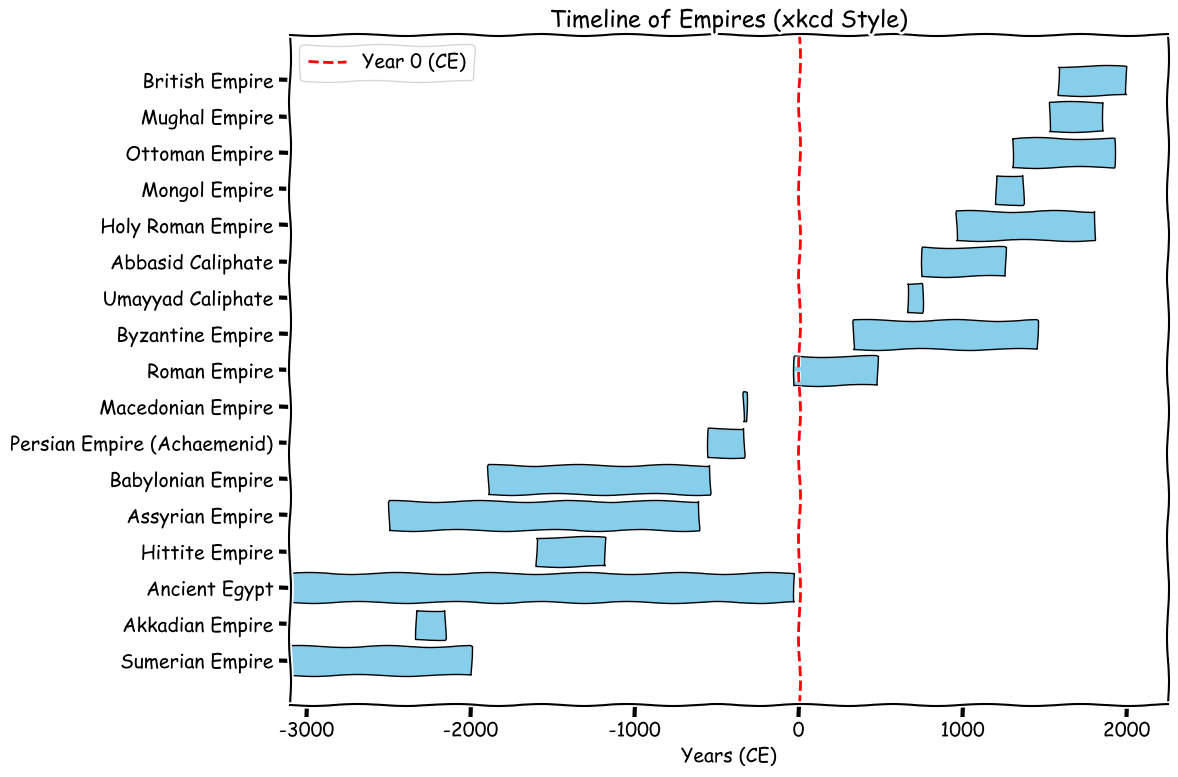

In [2]:
import matplotlib.pyplot as plt

# Enable xkcd style
plt.xkcd()

# Data for post-0 CE empires (name, start year, end year)
empires = [
    ("Sumerian Empire", -3100, -2000),
    ("Akkadian Empire", -2334, -2154),
    ("Ancient Egypt", -3100, -30),
    ("Hittite Empire", -1600, -1178),
    ("Assyrian Empire", -2500, -609),
    ("Babylonian Empire", -1894, -539),
    ("Persian Empire (Achaemenid)", -550, -330),
    ("Macedonian Empire", -336, -323),
    ("Roman Empire", -27, 476),  # Western Roman Empire
    ("Byzantine Empire", 330, 1453),  # Eastern Roman Empire
    ("Umayyad Caliphate", 661, 750),
    ("Abbasid Caliphate", 750, 1258),
    ("Holy Roman Empire", 962, 1806),
    ("Mongol Empire", 1206, 1368),
    ("Ottoman Empire", 1299, 1923),
    ("Mughal Empire", 1526, 1857),
    ("British Empire", 1583, 1997),  # Largest empire in history
]

# Extract data for plotting
names = [empire[0] for empire in empires]
start_years = [empire[1] for empire in empires]
durations = [empire[2] - empire[1] for empire in empires]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bars
y_positions = range(len(empires))
ax.barh(y_positions, durations, left=start_years, color="skyblue", edgecolor="black")

# Add empire names to the y-axis
ax.set_yticks(y_positions)
ax.set_yticklabels(names)

# Add labels and title
ax.set_xlabel("Years (CE)")
ax.set_title("Timeline of Empires (xkcd Style)")

# Highlight important periods
ax.axvline(0, color="red", linestyle="--", label="Year 0 (CE)")
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
